In [7]:
import pandas as pd
import math
import numpy
import sys
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append('./')
fs = 16
font = {'size'   : fs}
mpl.rc('font', **font)


scal_cols=['code','kernel','m','t1','nb','nmpi','p','q','time','gflops','t2']


hsched_cols2=['sched','m','mb','nnodes','p','q','time','nb','maxsub','minsub','nthreads', 'jobid','iavgrk', 'iminhsched_cols2rk', 'imaxrk', 'favgrk', 'fminrk', 'fmaxrk', 'tproblem','tcompress']
colspecv2=['code','sched','m','mb','nnodes','p','q','time','gflops','nb','maxsub','minsub','nthreads', 'jobid','iavgrk', 'iminrk', 'imaxrk', 'favgrk', 'fminrk', 'fmaxrk', 'tproblem','tcompress', 'fixedrank', 'fixedacc','wavek', 'hostname','binary','shmaxrk', 'shprob', 'shdecay']
fhminmax='res/2017-09-24-hicma-maxrk50-1.txt'
fhminmax='res/2017-10-17-hicma-2M-1.txt'
fhminmax='res/2017-10-17-hicma-2M-2.txt'
fhminmax='res/2017-10-17-hicma-2M-3.txt'
fhicma='res/2017-10-18-hicma-3M-1.txt'




global_nplist=[8, 16, 32, 64,128, 256, 512, 1024]
global_nplist=[1]
#df_hicma = df_hicma[df_hicma.m <= 594000]
#df_hicma = df_hicma[df_hicma.m > 594000]
#df_scalm = df_scalm[df_scalm.m > 594000]
#print(df_hicma)
#from common import *
#print(katrial)
#print(appmarkers)
#sys.exit()

In [70]:
host2arch={'isambard':'ARM@2.5GHz-2x32', 
           'shihab':'Haswell@2.5GHz-2x18', 
           'jasmine':'Broadwell@2.4GHz-2x14', 
           'flamingo':'Skylake@2.1GHz-2x28'}
host2cpu={'isambard':'ARM', 
           'shihab':'Haswell', 
           'jasmine':'Broadwell', 
           'flamingo':'Skylake'}

def fig_finalize(fig, ax, plt, plotname, legncol=2, legloc=4, ylim=None, 
                 xpoints=[80,170,260,350,440,600,800],
                 ypoints=[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000], title=None,
                 yscale=None, xscale=None, bbox_to_anchor=[1.3,1.05], points=[4,6,8,10,12,14]
                ):
    print(plotname)
    #ax.set_xlabel("Matrix size",fontweight='bold')
    #ax.set_ylabel("Time(s)",fontweight='bold')
    
    #proposal
    ax.set_xlabel("Matrix size")
    ax.set_ylabel("Time(s)")
    if ylim is not None: ax.set_ylim(ylim)

    ax.yaxis.grid(True, which='both')
    if title is not None:
        ax.set_title(title)
        #ax.set_title('TLR (HiCMA) vs Dense (ScaLAPACK-libsci) POTRF Results on Shaheen')

    if legncol is None:
        legncol=1
    if legloc is None:
        legloc=4
    if legloc == 100:
        plt.legend(handlelength=5, loc=4,ncol=legncol, columnspacing=1, bbox_to_anchor=bbox_to_anchor,
                  borderaxespad=0.25)
            #lgd=plt.legend(handlelength=3,loc='lower right',fontsize=12) #, bbox_to_anchor=(1, 0.5))
            #bbox_extra_artists=(lgd,), bbox_inches='tight'
    else:
        plt.legend(handlelength=3,loc=legloc, ncol=legncol, columnspacing=1) #fontsize
 

    if yscale is not None:
        ax.set_yscale(yscale)
    if xscale is not None:
        ax.set_xscale(xscale)
    #ax.set_xscale('log')

    if True:
        plt.minorticks_on()#ax.minorticks_on()
        #ax.xaxis.grid(True, which='both')
        #return
        plt.minorticks_off()
        ticks=[i*13500 for i in points ]
        print('ticks', ticks)
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
        fig.canvas.draw()
        labels = [str(int(numpy.rint(i*13500/1000)))+'K' for i in points]
        print("labels:",labels)
        ax.set_xticklabels(labels)
        ax.xaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='major')
        ax.yaxis.grid(False, which='minor')
        ax.grid(color='gray', linestyle='-', linewidth=.5)
        for child in ax.get_children():
            if isinstance(child, mpl.spines.Spine):
                child.set_color('gray')
    fig.savefig(plotname+'.pdf', bbox_inches = 'tight');
    fig.savefig(plotname+'.png', bbox_inches = 'tight');
    plt.show()

    #ax.set_yscale('linear')
    #fig.savefig(plotname+'_ylinear.pdf');
    #plt.show()
appnames2={0:'N/A',1:'Syn',2:'2D',5:'Matern',6:'Synthetic',9:'3D'}
appnames={0:'N/A',1:'Syn',2:'',5:'Matern',6:'Synthetic',9:'3D'}
#https://matplotlib.org/gallery/lines_bars_and_markers/linestyles.html?highlight=linestyles
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'

linestyle_tuple = [
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),

     ('dashed',                (0, (5, 5))),
        ('loosely dashed',        (0, (5, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dotted',                (0, (1, 1))),
    
     ('loosely dotted',        (0, (1, 10))),

     ('densely dotted',        (0, (1, 1))),


     ('densely dashed',        (0, (5, 1))),


    
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10)))

]

def plot(df_hicma, df_scalm, plotname, show_data_labels=True, show_data=False, yhicma_display_compress=False, 
         nplist=global_nplist, legncol=None, legloc=None, ylim=None, 
         applist=None, accuracies=['1e-08'], yval='time',        
         xpoints=[80,170,260,350,440,600,800],
         ypoints=[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000],
         colnrows='m',colnumnodes='nnodes',showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress','shprob'], #,'nthreads','jobid'
         title=None, hostname=None, hosts=None, show_dense=True, yscale=None, xscale=None, bbox_to_anchor=[1.3,1.05],
         points=[4,6,8,10,12,14]
        ):
    #if plotname is not 'time_hsw_cluster':
    #    return
    ax=None
    fig=None
    figsize_width=6
    figsize_height=6
    
    #proposal
    #figsize_width=9
    #figsize_height=5.8
    
    if show_data_labels is True:
        figsize_width=15
        figsize_height=100

    fig, ax = plt.subplots(figsize=(figsize_width, figsize_height))
    npcolors={8:'red',16:'green',32:'magenta',64:'blue',128:'pink',256:'cyan',512:'black'}
    goodnpcolors={1:'black',8:'red',16:'#0ca7ab',32:'#59529c',64:'#fa3c3c',128:'#ecaf4d',256:'#6ea35e',4:'#26df2b'#406c9d'
                  ,2:'blue'}
    goodhostcolors={'isambard':'red','flamingo':'#0ca7ab','jasmine':'#59529c','X':'#fa3c3c','yellow':'#ecaf4d',
                    'shihab':'#6ea35e',512:'#26df2b'#406c9d'
                  ,1024:'blue'}
    """
    HICMA_STARSH_PROB_RND    1
 HICMA_STARSH_PROB_SS     2
 HICMA_STARSH_PROB_RNDUSR 3
 HICMA_STARSH_PROB_FILE   4
 HICMA_STARSH_PROB_GEOSTAT   5
 HICMA_STARSH_PROB_EDSIN  6
 """
    for ihost, host in enumerate(hosts):
        for iacc, acc in enumerate(accuracies):
            if show_dense is True:
                for inp, np in enumerate(global_nplist):
                    label='ScaLAPACK '+str(np) +' nodes'
                    label='Dense - Chameleon'
                    #nmpi=np*nmpi_per_node
                    df = df_scalm[(df_scalm.nnodes==np) & (df_scalm.hostname==host)]
                    if len(df) == 0:
                        continue
                    ax=df.plot(ax=ax,x='m', y='time',ls='-',marker='o',label=label, 
                               color=goodnpcolors[np],
                              markersize=markersize,mfc='white', mew=markeredgeweight, 
                               lw=linewidth, 
                               zorder=100, clip_on=False)
                    if show_data is True:
                        print('ScaLAPACK - '+str(np))
                        print(df[['m','nnodes','p','q','time']])

            if True:
                for inp, np in enumerate(nplist):
                    singleapp = False
                    if len(applist) == 1:
                        singleapp = True
                    for app in applist:
                        if singleapp:
                            label='HiCMA-' #+str(np)# +' nodes'
                            linestyle='-'
                            marker='o'
                            color=goodnpcolors[np]
                        else:
                            if hosts is not None:
                                label=host2cpu[host]+'-'+appnames2[app] #+'-'+str(np)# +' nodes'
                                color=goodhostcolors[host]
                                linestyle=linestyle_tuple[ihost][1]
                            if hostname is not None:
                                label='TLR - HiCMA - '+appnames[app] #+'-'+str(np)# +' nodes'
                                label='TLR - HiCMA'+appnames[app] #+'-'+str(np)# +' nodes'
                                color='black'
                                linestyle='--'
                            if len(nplist) > 1:
                                if np == 1:
                                    label += ' ' + str(np) + ' node'
                                else:
                                    label += ' ' + str(np) + ' nodes'
                                color=goodnpcolors[np]
                            marker=appmarkers[app]
                        if len(accuracies) > 1:
                            label+=' ('+str(acc)+')'
                        if acc == '1e-08':
                            mfc=None
                        else:
                            mfc='white'

                            #for label,color,marker in [[str(minsub)+' '+sched+' - HiCMA - '+str(np)+' nodes',npcolors[inp],"x"]]:
                        #df=df_hsched[(df_hsched['numnodes']==np)&(df_hsched['sched']==sched)&(df_hsched['iminsub']==minsub)]
                        dfnp=df_hicma[(df_hicma[colnumnodes]==np)
                                      &(df_hicma['sched']=='prio')
                                      &(df_hicma['shprob']==app)
                                      &(df_hicma.hostname==host)
                                      &(df_hicma.fixedacc==acc)
                                     ]
                        df=dfnp.loc[dfnp.groupby([colnrows])["time"].idxmin()]
                        if len(df) == 0:
                            continue
                        if show_data is True:
                            print(label)
                            #print(dfnp[['nnodes','m','mb','nb','minsub','time','jobid','tcompress']])
                            print(df[showdatacols]) #,'wavek'
                        ax=df.plot(ax=ax,x=colnrows, y=yval,ls=linestyle,marker=marker,label=label,
                                   color=color, alpha=1,
                                  markersize=markersize,mfc=mfc, mew=markeredgeweight, 
                                   lw=linewidth, zorder=100, clip_on=False)
                        if show_data_labels is True:
                            for xy,m,nb,jobid,time in zip(zip(df.m, df.time),df.m,df.mb,df.jobid,df.time):                                       # <--
                                ax.annotate(str(int(m/1000))+' '+str(nb)+'\n'+str(int(time))+'\n'+str(jobid), xy=xy, textcoords='data') # <--
                        if yhicma_display_compress is True:
                            ax=df.plot(ax=ax,x='m', y='tcompress',ls=None,marker='X',label='$T_{compress}$ - '+str(np),
                                       color=npcolors[inp],markersize=markersize)
    fig_finalize(fig, ax, plt, plotname, legncol, legloc, ylim, xpoints, ypoints, title, yscale, xscale,
                bbox_to_anchor, points)
    
def process(plotname, hicma_files, scal_files,  show_data_labels=False, show_data=False, 
            mlowerbound=0, mupperbound=1000000000, yhicma_display_compress=False, nplist=global_nplist,
            hicma_filesB=None, legncol=None, legloc=None, ylim=None,colspecs=None,
            applist=None,accuracies=['1e-08'],filterfunc=None,
            yval='time',waveklist=None, hostname=None, show_dense=True,
            xpoints=[80,170,260,350,440,600,800],
            ypoints=[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000],
            colnrows='m',colnumnodes='nnodes',showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress','shprob'],
            title=None, hosts=None, yscale=None, xscale=None, bbox_to_anchor=[1.3,1.05],
            points=[4,6,8,10,12,14]
           ):
    frames = []
    if colspecs is None:
        print("define colspecs")
        sys.exit()
    if len(colspecs) != len(hicma_files):
        print("colspecs and hicma_files should have same length")
        sys.exit()
    for ifile, f in enumerate(hicma_files):
        #print(f,colspecs[ifile])
        df = pd.read_csv(f, delim_whitespace=True,engine='python',index_col=False,header=None,names=colspecs[ifile])
        #print(df)
        frames.append(df)
    df_main = pd.concat(frames, ignore_index=True)
    #print(df_main.dtypes)
    #print(df_main)
    df_main['fixedacc']=df_main['fixedacc'].astype('str')
    #print(df_main.dtypes)
    if hostname is not None:
        df_main = df_main[df_main['hostname']==hostname]
    df_hicma = df_main[df_main['code']=='hic']
    df_scalm = df_main[df_main['code']=='cham']
    #print(df_hicma['fixedacc'].unique())
    #return
    if yval is "tcompcalc":
        df_hicma['tcompcalc'] = df_hicma['time'] + df_hicma['tcompress']
        
    df_hicma = df_hicma[df_hicma[colnrows] > mlowerbound]

    df_hicma = df_hicma[df_hicma[colnrows] < mupperbound]
    
    if filterfunc is not None:
        df_hicma=filterfunc(df_hicma)
    if waveklist is not None:
        df_hicma = df_hicma[(df_hicma['wavek'].isin(waveklist))]
    df_hicma = df_hicma[df_hicma[colnumnodes] < 1024]
    #dftmp=df_hicma#[df_hicma['shprob']==6.0] 
    #print(dftmp[['shprob','nnodes','m','mb','minsub','time','jobid','tcompress']])
    #sys.exit()
    plot(df_hicma, df_scalm, plotname, show_data_labels, show_data, yhicma_display_compress, 
         nplist, legncol, legloc, ylim,applist,accuracies, yval, xpoints, ypoints,colnrows,colnumnodes,
        showdatacols, title, hostname, hosts, show_dense, yscale, xscale, bbox_to_anchor, points)
    return df_hicma, df_scalm
appmarkers={0:'o',1:'o',2:'o'}
markersize=10
markeredgewidth=4
markeredgeweight=4
linewidth=2

lu-shmem-log
ticks [27000, 54000, 108000, 216000]
labels: ['27K', '54K', '108K', '216K']


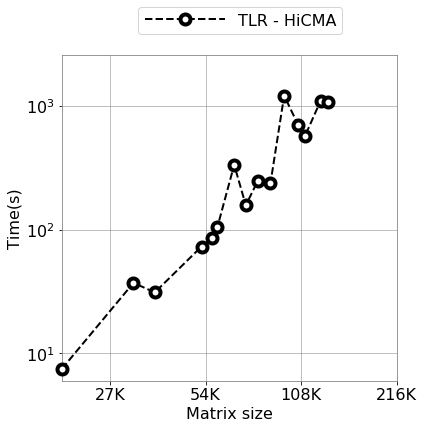

In [71]:
files=['~/rabab/exp/lu-outs/lu-jas2.log-grepped' #1e-4(not complete) 1e-6 1e-8
      ] 
colspecs=[colspecv2         ]


hosts = ['jasmine']
#hosts = ['isambard',  'flamingo']

for host in hosts:
    hostsarray=[host]
    for yscale in ['log']:
        df_hicma, df_scalm = process(plotname='lu-shmem-'+yscale, hicma_files=files, scal_files=[], 
            show_data_labels=False, show_data=False, mlowerbound=0, mupperbound=10000000, nplist=[1], legncol=2, legloc=100, 
            ylim=[6,2600], 
            colspecs=colspecs, 
            #applist=[6,1,5,2]
            accuracies=['0.01'], #,'0.0001'], 
            applist=[2,0], hostname=host, hosts=hostsarray, show_dense=False,
            showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
            title=None, yscale=yscale, xscale='log', bbox_to_anchor=[.85,1.05]
                                     ,points=[2,4,8,16]
                                     #,points=[14,20,40,80,170]
                    )
        #print(df_hicma)

/home/kadir/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 189000.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


arm-2d-8-log
ticks [189000, 270000, 540000, 1080000, 2295000]
labels: ['189K', '270K', '540K', '1080K', '2295K']


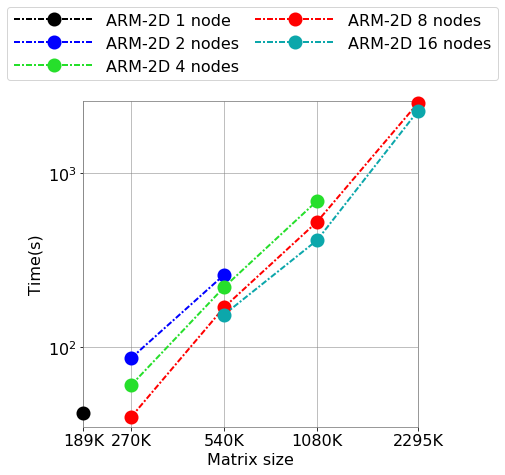

In [66]:
files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-07-hicma-isambard-1.txt'] #1e-8
files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-10-hicma-isambard-1.txt'] #1e-4(not complete) 1e-6 1e-8
files=['~/kexphicma/ipy/hicma-shaheen/res/2019-09-10-hicma-isambard-1.txt' #1e-4(not complete) 1e-6 1e-8
      , '~/kexphicma/ipy/hicma-shaheen/res/2019-09-13-hicma-isambard-1.txt' #2 4 8 16 nodes st-2d-sqexp
      ] 
colspecs=[colspecv2, colspecv2         ]


hosts = ['isambard']
#hosts = ['isambard',  'flamingo']


for yscale in ['log']:
    df_hicma, df_scalm = process(plotname='arm-2d-8-'+yscale, hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mlowerbound=170000, mupperbound=100594001, nplist=[1,2,4,8,16], legncol=2, legloc=100, 
        ylim=[35,2600], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        accuracies=['1e-08'], #,'0.0001'], 
        applist=[2,0], hostname=None, hosts=hosts, show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale=yscale, xscale='log', bbox_to_anchor=[1.25,1.05],points=[14,20,40,80,170]
                )

In [22]:
files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-07-hicma-isambard-1.txt'] #1e-8
files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-10-hicma-isambard-1.txt'] #1e-4(not complete) 1e-6 1e-8
colspecs=[colspecv2         ]


hosts = ['isambard', 'shihab', 'jasmine', 'flamingo']
#hosts = ['isambard',  'flamingo']


for yscale in ['log','linear']:
    df_hicma, df_scalm = process(plotname='2d3d-6-'+yscale, hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legncol=2, legloc=100, 
        ylim=[1,300], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        accuracies=['1e-06'], #,'0.0001'], 
        applist=[9,2,0], hostname=None, hosts=hosts, show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale=yscale, bbox_to_anchor=[1.1,1.05]
                )

    df_hicma, df_scalm = process(plotname='2d3d-8-'+yscale, hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legncol=2, legloc=100, 
        ylim=[1,300], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        accuracies=['1e-08'], #,'0.0001'], 
        applist=[9,2,0], hostname=None, hosts=hosts, show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale=yscale, bbox_to_anchor=[1.1,1.05]
                )
    
if False: df_hicma, df_scalm = process(plotname='2d3d', hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legncol=2, legloc=100, 
        ylim=[1,300], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        accuracies=['1e-06','1e-08'], #,'0.0001'], 
        applist=[9,2,0], hostname=None, hosts=hosts, show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale='linear'
                )
if False: df_hicma, df_scalm = process(plotname='2d', hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legncol=2, legloc=100, 
        ylim=[1.5,50], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        accuracies=['1e-06','1e-08'], #,'0.0001'], 
        applist=[2,0], hostname=None, hosts=hosts, show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale='linear'
                )
if False: df_hicma, df_scalm = process(plotname='3d', hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legncol=2, legloc=100, 
        ylim=[10,300], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        accuracies=['1e-06','1e-08'], #,'0.0001'], 
        applist=[9,0], hostname=None, hosts=hosts, show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale='linear'
                )
#    break

FileNotFoundError: [Errno 2] No such file or directory: '/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-10-hicma-isambard-1.txt'

2d3d-8-log
ticks [54000, 81000, 108000, 135000, 162000, 189000]
labels: ['54K', '81K', '108K', '135K', '162K', '189K']


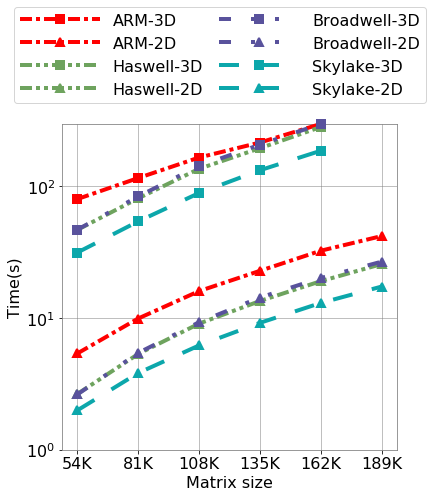

In [11]:
files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-07-hicma-isambard-1.txt'] #1e-8
colspecs=[colspecv2         ]


#for hostname in ['isambard', 'shihab', 'jasmine', 'flamingo']:
#    print(hostname)
    
df_hicma, df_scalm = process(plotname='2d3d-8-log', hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legncol=2, legloc=100, 
        ylim=[1,300], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        applist=[9,2,0], hostname=None, hosts=['isambard', 'shihab', 'jasmine', 'flamingo'], show_dense=False,
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=None, yscale='log', bbox_to_anchor=[1.1,1.05]
                )
#    break

isambard
hicma_cham_isambard
ticks [54000, 81000, 108000, 135000, 162000, 189000]
labels: ['54K', '81K', '108K', '135K', '162K', '189K']


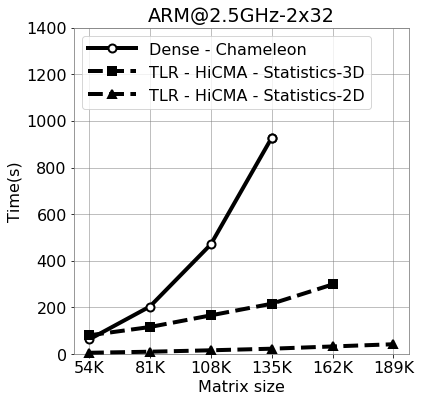

shihab
hicma_cham_shihab
ticks [54000, 81000, 108000, 135000, 162000, 189000]
labels: ['54K', '81K', '108K', '135K', '162K', '189K']


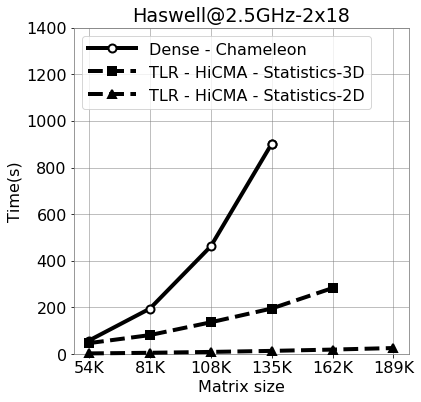

jasmine
hicma_cham_jasmine
ticks [54000, 81000, 108000, 135000, 162000, 189000]
labels: ['54K', '81K', '108K', '135K', '162K', '189K']


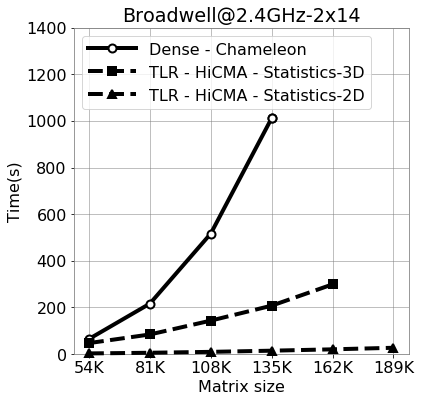

flamingo
hicma_cham_flamingo
ticks [54000, 81000, 108000, 135000, 162000, 189000]
labels: ['54K', '81K', '108K', '135K', '162K', '189K']


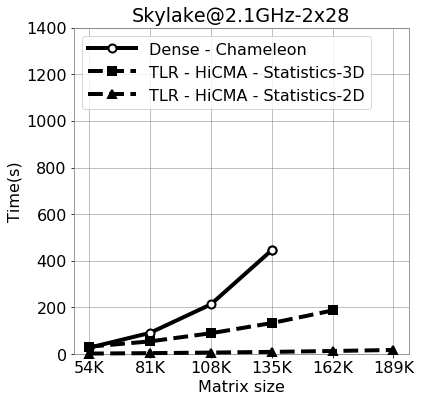

In [12]:
files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2019-09-07-hicma-isambard-1.txt']
colspecs=[colspecv2         ]
host2arch={'isambard':'ARM@2.5GHz-2x32', 
           'shihab':'Haswell@2.5GHz-2x18', 
           'jasmine':'Broadwell@2.4GHz-2x14', 
           'flamingo':'Skylake@2.1GHz-2x28'}
"""2	32	2.5
2	18	2.3
2	14	2.4
2	28	2.1"""
for hostname in ['isambard', 'shihab', 'jasmine', 'flamingo']:
    print(hostname)
    df_hicma, df_scalm = process(plotname='hicma_cham_'+hostname, hicma_files=files, scal_files=[], 
        show_data_labels=False, show_data=False, mupperbound=594001, nplist=[1], legloc=2, ylim=[1,1400], 
        colspecs=colspecs, 
        #applist=[6,1,5,2]
        applist=[9,2,0], hostname=hostname, hosts=[hostname],
        showdatacols=['m','mb','nb','shmaxrk','fmaxrk','favgrk','time','tcompress'], #,'p', 'q', 'wavek'
        title=host2arch[hostname]
                )

In [27]:
#print(df_hicma.p, df_hicma.q)
#print('Scalapack m sizes:',df_scalm[['m','nb']])
#print('Hicma m sizes:',df_hicma[df_hicma.m<=594000][['m','mb']])

In [225]:
if True: process(plotname='time_hsw_cluster_with_tcompress', hicma_files=files, scal_files=[fscal], 
        show_data_labels=False, show_data=True, mupperbound=594001, nplist=[16], legloc=2, ylim=[1,10000], 
                 colspecs=colspecs, 
                 #applist=[6,1,5,2]
                 applist=[6,2],
                 yval='tcompcalc'
                )

NameError: name 'fscal' is not defined

HiCMA-16
           m    mb  nb  shmaxrk  fmaxrk  favgrk     time    jobid  tcompress  \
108  1080000  2700  50      NaN     NaN     NaN  189.389  4315162        NaN   
113  2295000  3375  50      NaN     NaN     NaN  777.520  4315167        NaN   

     nthreads  
108        31  
113        31  
HiCMA-32
           m    mb  nb  shmaxrk  fmaxrk  favgrk      time    jobid  tcompress  \
116  1080000  2700  50      NaN     NaN     NaN   148.577  4315190        NaN   
124  2295000  2700  50      NaN     NaN     NaN   509.515  4315194        NaN   
130  3510000  4500  50      NaN     NaN     NaN  1698.310  4315200        NaN   

     nthreads  
116        31  
124        31  
130        31  
HiCMA-64
           m    mb  nb  shmaxrk  fmaxrk  favgrk      time    jobid  tcompress  \
131  1080000  2700  50      NaN     NaN     NaN   135.068  4315218        NaN   
135  2295000  2700  50      NaN     NaN     NaN   447.957  4315222        NaN   
140  3510000  3375  50      NaN     NaN     NaN   99

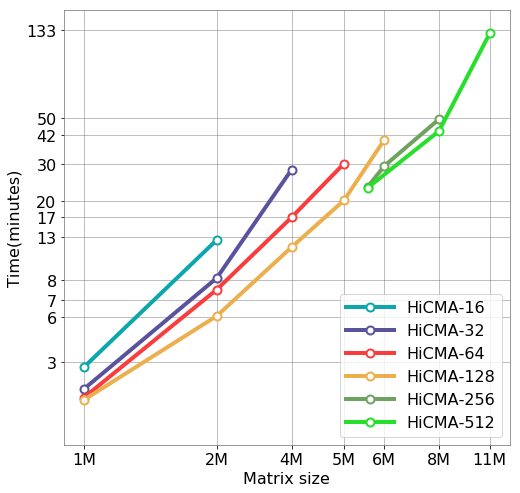

HiCMA-16
          m    mb  nb  shmaxrk  fmaxrk    favgrk     time    jobid  tcompress  \
5   1080000  2700  50      NaN    28.0  10.07920  191.065  5394497    121.243   
34  2295000  3000  50      NaN    24.0   8.15682  821.041  5394527    537.616   

    nthreads  
5         31  
34        31  
HiCMA-32
           m    mb  nb  shmaxrk  fmaxrk    favgrk      time    jobid  \
57   1080000  2700  50      NaN    28.0  10.07920   134.844  5394665   
117  2295000  3000  50      NaN    24.0   8.15682   554.537  5394695   
150  3510000  3375  50      NaN    23.0   7.45861  1240.776  5394725   

     tcompress  nthreads  
57     62.0745        31  
117   271.3750        31  
150   622.1760        31  
HiCMA-64
           m    mb  nb  shmaxrk  fmaxrk    favgrk      time    jobid  \
167  1080000  2700  50      NaN    28.0  10.07920   109.673  5394833   
196  2295000  3000  50      NaN    24.0   8.15682   432.595  5394863   
226  3510000  3375  50      NaN    23.0   7.45861   998.694  5394893   

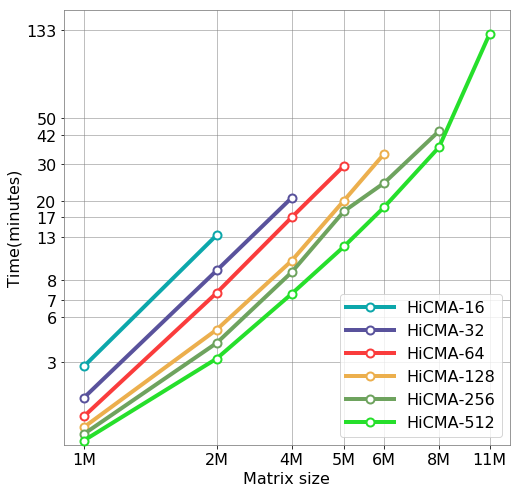

In [9]:
def filterfunc1(df_hicma):
    return df_hicma[(df_hicma.nnodes < 256)|((df_hicma.nnodes >= 256) & (df_hicma.m > 5400000))]
def filterfunc1a(df_hicma):
    return df_hicma[(df_hicma.nnodes <= 256)]

files=['res/2017-10-19-hicma-50K500K-1.txt', 'res/2017-10-20-hicma-10M-3.txt']
colspecs=[hsched_cols2,hsched_cols2]
ff=filterfunc1a
ff=None
plotname='time_hsw_cluster_BIG_ss_wo512'
if True:process(plotname=plotname, hicma_files=files, 
        scal_files=[fscal], show_data_labels=False, mlowerbound=594000,
        show_data=True, yhicma_display_compress=False, legloc=4, ylim=[80,10000], 
                colspecs=colspecs, applist=[2],filterfunc=ff)

files=['/Users/akbudak/kexphicma/ipy/hicma-shaheen/res/2018-04-17-hicma-threads-updatecham-1.txt']
colspecs=[hsched_cols2]
ff=None
plotname='time_hsw_cluster_BIG_ss_bestthread'
if True:process(plotname=plotname, hicma_files=files, 
        scal_files=[fscal], show_data_labels=False, mlowerbound=594000,
        show_data=True, yhicma_display_compress=False, legloc=4, ylim=[80,10000], 
                colspecs=colspecs, applist=[2],filterfunc=ff,
               ypoints=[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000]
               )

if False:process(plotname='time_hsw_cluster_BIG', hicma_files=files, 
        scal_files=[fscal], show_data_labels=False, 
        mlowerbound=594000, show_data=True)


HiCMA-16
           m    mb  nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
337  1080000  3000  30      100    29.0  17.9697   226.615  5028130   
457  2295000  3375  30      100    25.0  15.2602  1063.212  5028303   

     tcompress  nthreads  
337    119.213        31  
457    535.461        31  
HiCMA-32
           m    mb  nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
344  1080000  2700  30      100    28.0  17.3538   135.768  5028157   
352  2295000  3000  30      100    24.0  14.7392   609.646  5028162   
479  3510000  4500  30      100    24.0  14.9558  1536.284  5028336   

     tcompress  nthreads  
344    61.2384        31  
352   267.2600        31  
479   615.4690        31  
HiCMA-64
           m    mb  nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
480  1080000  2700  30      100    28.0  17.3538   113.872  5028353   
482  2295000  3000  30      100    24.0  14.7392   426.978  5028358   
374  3510000  3375  30      100    23.0  13.6373  1044.485  5028195   
4

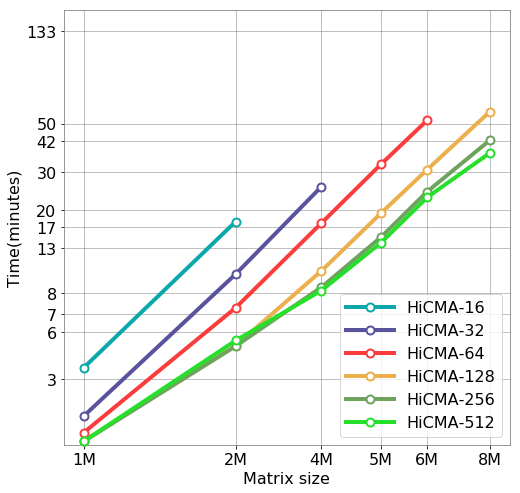

In [10]:
def filterfunc2(df_hicma):
    return df_hicma[(df_hicma.nnodes < 256)|((df_hicma.nnodes >= 256) & (df_hicma.m > 2000000))]
files=['res/2018-02-13-hicma-edsin-scale-1.txt']
files=['res/2018-02-17-hicma-edsin-scale-1.txt']
colspecs=[colspecv2]
if True:process(plotname='time_hsw_cluster_BIG_edsin_wavek25', hicma_files=files, 
        scal_files=[fscal], show_data_labels=False, mlowerbound=594000,
        show_data=True, yhicma_display_compress=False, legloc=4, ylim=[100,10000], 
        colspecs=colspecs, applist=[6],waveklist=[25],
        xpoints=[80,170,260,350,440,600]
               )
    #,filterfunc=filterfunc2)

HiCMA-16
           m    mb  nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
322  1080000  3375  50      500    43.0  25.6130   272.447  5027621   
327  2295000  4500  50      500    40.0  22.5574  1231.431  5027626   

     tcompress  nthreads  
322    277.482        31  
327   1168.040        31  
HiCMA-32
           m    mb   nb  shmaxrk  fmaxrk   favgrk     time    jobid  \
331  1080000  3000   50      500    43.0  24.7486  157.599  5027648   
222  2295000  3375  100      200    36.0  20.3697  866.724  5025642   

     tcompress  nthreads  
331    144.833        31  
222    331.150        31  
HiCMA-64
           m    mb   nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
224  1080000  2700  100      200    41.0  23.7887   138.672  5025664   
230  2295000  3375  100      200    36.0  20.3697   641.187  5025670   
234  3510000  4500  100      200    35.0  19.8480  1367.370  5025675   

     tcompress  nthreads  
224    37.8389        31  
230   169.1460        31  
234   376.329

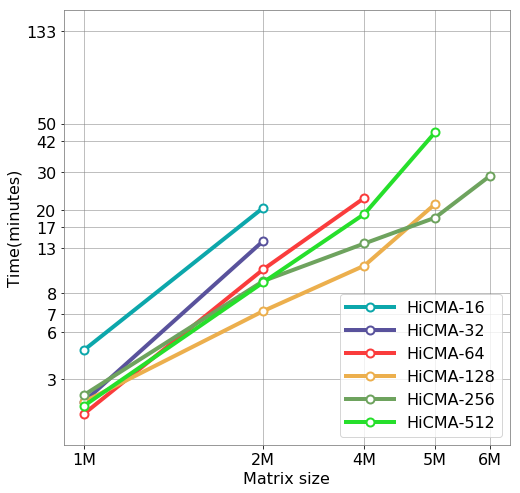

In [11]:
files=['res/2018-02-13-hicma-edsin-scale-1.txt']
files=['res/2018-02-17-hicma-edsin-scale-1.txt']
colspecs=[colspecv2]
if True:process(plotname='time_hsw_cluster_BIG_edsin_wavek50', hicma_files=files, 
        scal_files=[fscal], show_data_labels=False, mlowerbound=594000,
        show_data=True, yhicma_display_compress=False, legloc=4, ylim=[100,10000], 
                colspecs=colspecs, applist=[6],waveklist=[50],
                        xpoints=[80,170,260,350,440]
               ) #,filterfunc=filterfunc2)

HiCMA-16
          m    mb   nb  shmaxrk  fmaxrk   favgrk     time    jobid  tcompress  \
31  1080000  3375  150      250    69.0  35.9142  385.142  4993929      161.0   

    nthreads  
31        31  
HiCMA-32
          m    mb   nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
36  1080000  3000  150      250    66.0  34.5914   224.920  4993956   
42  2295000  4500  150      250    61.0  31.0624  1009.597  4993962   

    tcompress  nthreads  
36    83.4463        31  
42   351.0450        31  
HiCMA-64
          m    mb   nb  shmaxrk  fmaxrk   favgrk     time    jobid  tcompress  \
45  1080000  3375  150      250    69.0  35.9142  199.115  4993985    41.2462   
50  2295000  4500  150      250    61.0  31.0624  691.502  4993990   173.3400   

    nthreads  
45        31  
50        31  
HiCMA-128
          m    mb   nb  shmaxrk  fmaxrk   favgrk      time    jobid  \
56  1080000  3375  150      250    69.0  35.9142   184.865  4994013   
63  2295000  3375  150      250    54.0  27.747

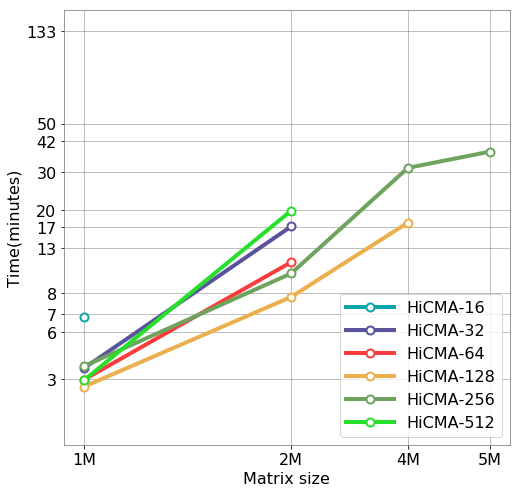

In [12]:
files=['res/2018-02-13-hicma-edsin-scale-1.txt']
colspecs=[colspecv2]
if True:process(plotname='time_hsw_cluster_BIG_edsin_wavek100', hicma_files=files, 
        scal_files=[fscal], show_data_labels=False, mlowerbound=594000,
        show_data=True, yhicma_display_compress=False, legloc=4, ylim=[100,10000], 
                colspecs=colspecs, applist=[6],waveklist=[100],
                                       xpoints=[80,170,260,350]
               ) #,filterfunc=filterfunc2)

time_skl_cluster_BIG_ss_turbooff
xticks [1080000, 2295000, 3510000, 4725000, 5940000, 8100000, 10800000]
labels: ['1M', '2M', '4M', '5M', '6M', '8M', '11M']
yticks [200, 330, 400, 500, 800, 1000, 1200, 1800, 2500, 3000, 8000]
labels: ['3', '6', '7', '8', '13', '17', '20', '30', '42', '50', '133']


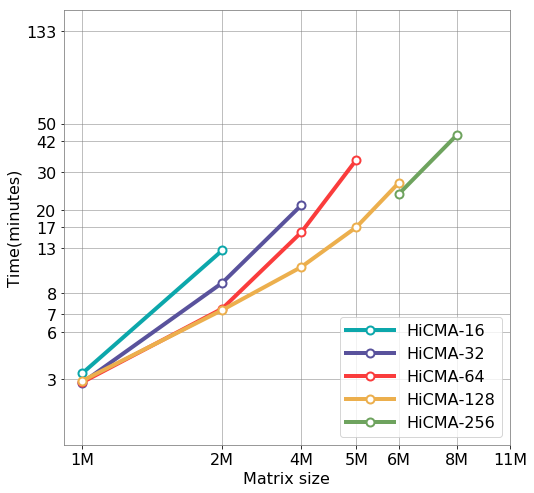

In [13]:

files=['res/2018-02-12-hicma-skylake-turbooff-1.txt']
colspecs=[colspecv2]
if True:process(plotname='time_skl_cluster_BIG_ss_turbooff', hicma_files=files, 
        scal_files=[], show_data_labels=False, mlowerbound=594000,
        show_data=False, yhicma_display_compress=False, legloc=4, ylim=[100,10000], 
                colspecs=colspecs, applist=[2],)

time_skl_cluster_BIG_ss_turboon
xticks [1080000, 2295000, 3510000, 4725000, 5940000, 8100000, 10800000]
labels: ['1M', '2M', '4M', '5M', '6M', '8M', '11M']
yticks [200, 330, 400, 500, 800, 1000, 1200, 1800, 2500, 3000, 8000]
labels: ['3', '6', '7', '8', '13', '17', '20', '30', '42', '50', '133']


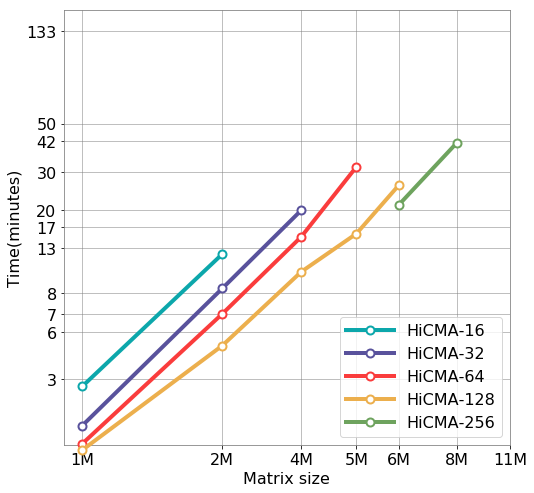

In [14]:
files=['res/2018-02-12-hicma-skylake-turboon-1.txt'] #just show on
colspecs=[colspecv2]
if True:process(plotname='time_skl_cluster_BIG_ss_turboon', hicma_files=files, 
        scal_files=[], show_data_labels=False, mlowerbound=594000,
        show_data=False, yhicma_display_compress=False, legloc=4, ylim=[100,10000], 
                colspecs=colspecs, applist=[2])

time_skl_cluster_BIG_ss_turboon_lessthreads
xticks [1080000, 2295000, 3510000, 4725000, 5940000, 8100000, 10800000]
labels: ['1M', '2M', '4M', '5M', '6M', '8M', '11M']
yticks [200, 330, 400, 500, 800, 1000, 1200, 1800, 2500, 3000, 8000]
labels: ['3', '6', '7', '8', '13', '17', '20', '30', '42', '50', '133']


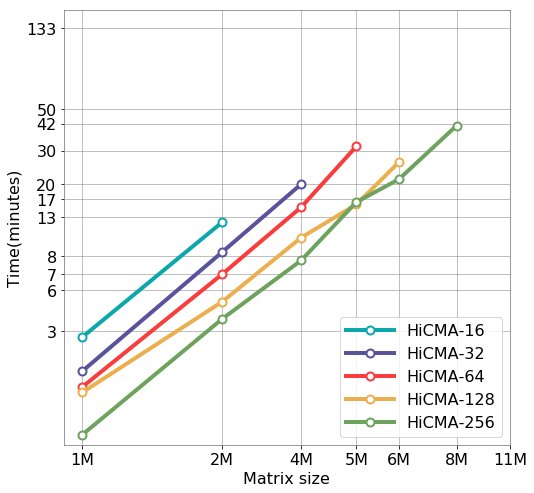

In [13]:
files=['res/2018-02-12-hicma-skylake-turboon-1.txt','res/2018-05-15-hicma-skylake-turboon-1.txt','res/2018-06-11-hicma-skylake-turboon-1.txt'] #just show on
colspecs=[colspecv2,colspecv2,colspecv2]
if True:process(plotname='time_skl_cluster_BIG_ss_turboon_lessthreads', hicma_files=files, 
        scal_files=[], show_data_labels=False, mlowerbound=594000,
        show_data=False, yhicma_display_compress=False, legloc=4, ylim=[50,10000], 
                colspecs=colspecs, applist=[2])